# Port Congestion in China (Capes)

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/PortCongestion/Port_Congestion_in_China-Capes.ipynb)

- Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and replace it below:

In [1]:
signal_ocean_api_key = ""  # replace with your subscription key

## Setup

- Install the Signal Ocean SDK and import all required modules:

In [3]:
%%capture
!pip install signal-ocean

from signal_ocean import Connection
connection = Connection(signal_ocean_api_key)

from signal_ocean import Connection
from signal_ocean.port_congestion import PortCongestion
from signal_ocean.voyages import VoyagesAPI, VesselClass, VesselClassFilter

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from functools import reduce
import plotly.express as px

# Create instances of APIs used throughout this notebook:
connection = Connection(signal_ocean_api_key)
voyages_api =VoyagesAPI(connection)
port_congestion = PortCongestion(connection)

## Calculate Port Congestion

### Get Data (Port Congestion Package)

- Define the Port Congestion parameters

In [5]:
vessel_class = voyages_api.get_vessel_classes(VesselClassFilter('cape'))[0]
vessel_class_id = vessel_class.vessel_class_id

# Port/Areas of interest
ports = ['Qingdao']
areas = ['Central China','North China','South China']

# Start date for Port Congestion Calculation (Last 6 months)
congestion_start_date = date.today() - relativedelta(months=6)

In [6]:
(number_of_vessels_over_time,
waiting_time_over_time,
live_port_congestion,
vessels_congestion_data) = port_congestion.get_port_congestion(
    congestion_start_date,
    vessel_class_id,
    areas = areas,
    ports = ports
)

### Define helper functions

In [7]:
# Helper Function that adds date buttons in time series visualisations
def add_date_buttons(months_back, time_series,date_buttons):
    current_date = datetime.utcnow().date()
    past_date = current_date - pd.DateOffset(months=months_back)
    if (months_back < 12):
        label_m = str(months_back) + 'm'
        if past_date >= time_series.date.min(): date_buttons.append(dict(count = months_back, label = label_m, step = "month", stepmode = "backward"))
    else:
        label_y = str(int(months_back/12)) + 'y'
        if past_date >= time_series.date.min(): date_buttons.append(dict(count = int(months_back/12), label = label_y, step = "year", stepmode = "backward"))
    return date_buttons

In [8]:
def plot_number_of_vessels_over_time(num_of_vessels_time_series):
    fig = px.line(num_of_vessels_time_series, x='date', y='vessels', 
              title = f'Number of Vessels Over Time')

    fig.update_traces(hovertemplate='Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Vessels: %{y}')

    # Add buttons with dates, if applicable
    date_buttons = []
    date_buttons = add_date_buttons(1, num_of_vessels_time_series,date_buttons) # 1 month back
    date_buttons = add_date_buttons(6, num_of_vessels_time_series,date_buttons) # 6 months back
    date_buttons.append(dict(count = 1, label = "YTD", step = "year", stepmode = "todate"))
    fig.update_xaxes(rangeslider_visible = True, rangeselector = dict(buttons = date_buttons))
    fig.update_layout(
      width=1000,
      height=500,
      plot_bgcolor = 'rgba(0,0,0,0.05)')

    fig.show() 
    
def plot_waiting_time_over_time(waiting_time_df):

    fig = px.line(waiting_time_df, x = 'date', y = 'avg_waiting_time', 
                title = f'Waiting Time - 7 days Moving Average')

    fig.update_traces(hovertemplate='Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>7d MA: %{y:.1f}')

    # Add buttons with dates, if applicable
    date_buttons = []
    date_buttons = add_date_buttons(1, waiting_time_df,date_buttons) # 1 month back
    date_buttons = add_date_buttons(6, waiting_time_df,date_buttons) # 6 months back
    date_buttons.append(dict(count = 1, label = "YTD", step = "year", stepmode = "todate"))

    fig.update_xaxes( rangeslider_visible = True, rangeselector = dict(buttons = date_buttons))
    fig.update_yaxes(title_text = 'Waiting Days')
    fig.update_layout(
      width=1000,
      height=500,
      plot_bgcolor = 'rgba(0,0,0,0.05)')

    fig.show()
    
def plot_live_port_congestion_heatmap(vessels_at_port_df):
    fig = px.density_mapbox(vessels_at_port_df, lat = 'latitude', lon = 'longitude', z = 'days_at_port', radius = 10,
                          center = dict(lat = 0, lon = 150),zoom = 1, mapbox_style = "stamen-terrain",
                          custom_data = ['imo', 'vessel_name', 'purpose', 'port_name_geos', 'arrival_date', 'days_at_port'])
    fig.update_layout(
      title = "Today's Activity", 
      title_x = 0.5,
      width=1000,
      height=500)
    fig.update_traces(hovertemplate = 'IMO: %{customdata[0]} <br>Vessel Name: %{customdata[1]} <br>Purpose: %{customdata[2]} <br>Port: %{customdata[3]} <br>Arrival Date: %{customdata[4]} <br>Days at port: %{customdata[5]:.1f}')
    fig.show()
    
def calculate_busiest_ports(live_port_congestion):
    aggregated_df = (
        live_port_congestion[
            (live_port_congestion.area_name_level0_geos.isin(
                ['Central China','North China', 'South China'])
            )
        ]
        .groupby(['port_name_geos','mode'])
        .imo
        .nunique()
        .reset_index()
        .rename(columns = {'imo':'num_of_vessels'})
    )

    top_10_busy_ports = (
        aggregated_df.
        groupby('port_name_geos')
        .num_of_vessels
        .sum()
        .sort_values(ascending = False)
        .head(10)
        .index  
    )

    aggregated_df = (
        aggregated_df[aggregated_df.port_name_geos.isin(top_10_busy_ports)]    
    )

    return aggregated_df
    
def plot_busiest_ports_barplot(busiest_ports):
    colors = ['rgba(38, 24, 74, 0.8)', 'rgba(122, 120, 168, 0.8)']
    fig = px.bar(busiest_ports, 
              y = 'port_name_geos', 
              x = 'num_of_vessels', 
              color= 'mode', 
              title="Today's Activity - Top Ports", 
              orientation = 'h', 
              color_discrete_sequence = colors, 
              text = 'num_of_vessels', 
              custom_data = ['mode'])

    fig.update_layout(
      width=1000,
      height=500, 
      xaxis_title= 'Number of Vessels', yaxis_title = 'Port', barmode = 'stack', 
      yaxis = {'categoryorder':'total ascending'}
    ) 

    fig.update_traces(hovertemplate = '%{y} <br>%{customdata[0]}: %{x}<extra></extra>')
    fig.show()

## Results

- **Number of Vessels**

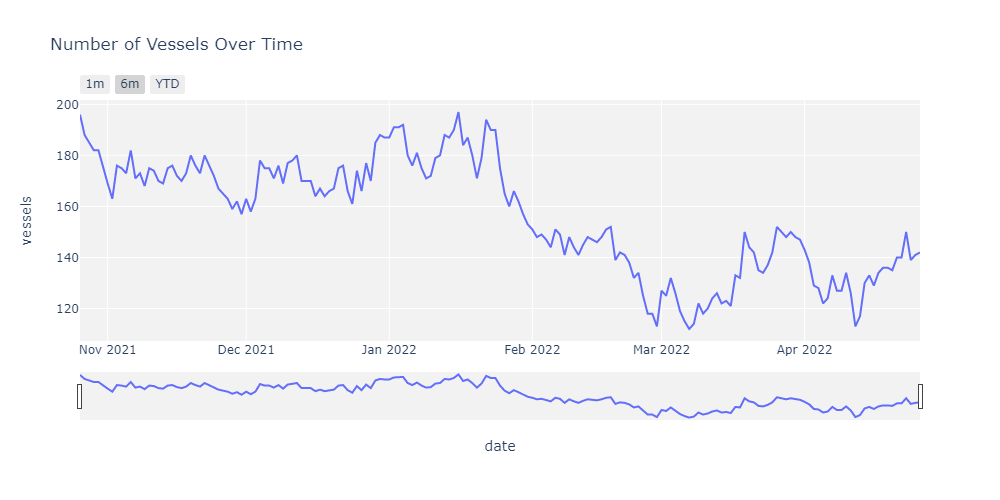

In [9]:
plot_number_of_vessels_over_time(number_of_vessels_over_time)

- **Waiting time**

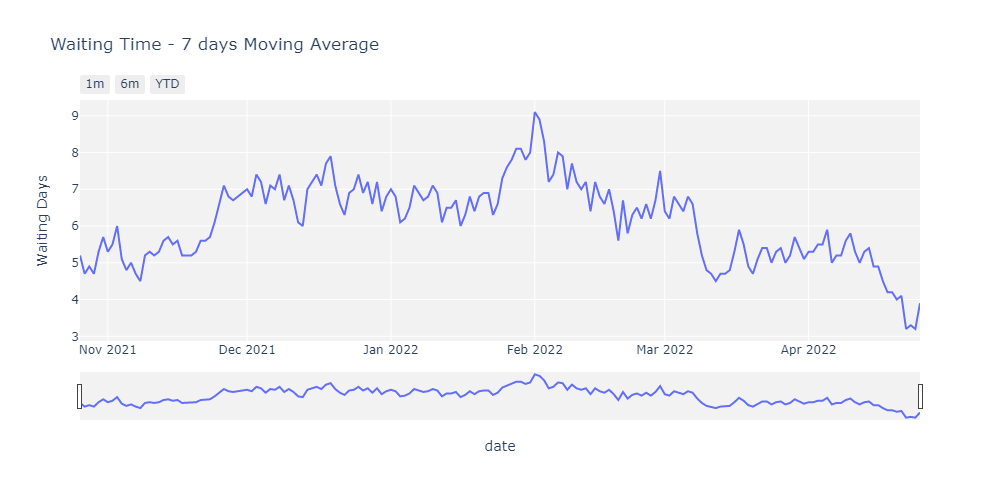

In [10]:
plot_waiting_time_over_time(waiting_time_over_time)

- **Congestion Heatmap**

In this example we are displaying the density of the measure 'days at port' around the world.  
Days at port correspond to the difference between current date and port call arrival date.

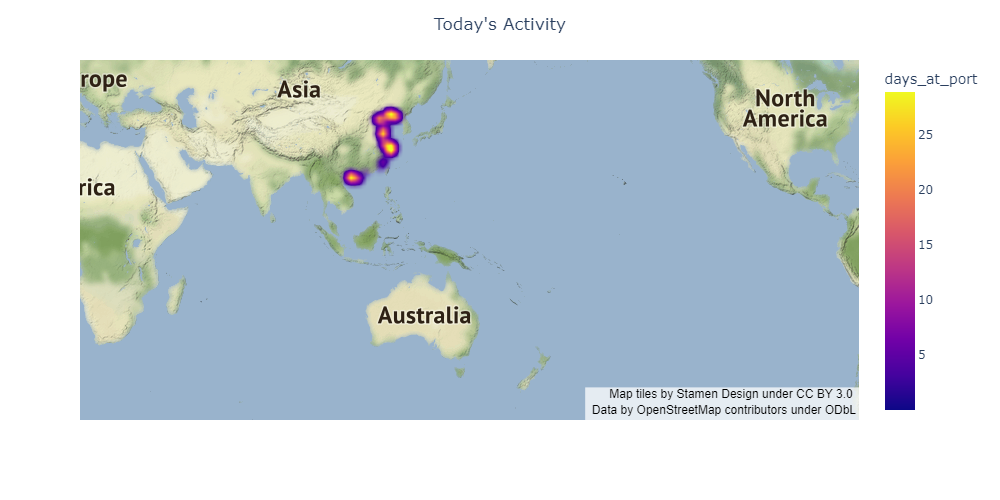

In [11]:
plot_live_port_congestion_heatmap(live_port_congestion)

- **Busiest Ports**

In [12]:
live_port_congestion

,imo,vessel_name,purpose,port_name_geos,country_geos,area_name_level0_geos,waiting_time_start,waiting_time_end,operating_time_start,operating_time_end,day_date,mode,geo_asset_name,latitude,longitude,arrival_date,days_at_port
0,9226633.0,Sunny Conakry,Discharge,Yantai,China,North China,2022-04-23 19:55:47,2022-04-24 23:59:00,2022-04-25 11:55:24,2022-04-26 10:58:32,2022-04-26,Operating,Yantai Bulk Terminal,37.7174,121.1133,2022-04-23 19:55:47,2.169595
1,9233923.0,Atlantis,Discharge,Jingtang,China,North China,2022-04-20 11:56:29,2022-04-21 23:59:00,2022-04-22 03:55:29,2022-04-26 07:55:32,2022-04-26,Operating,Jingtang Bulk Terminal,39.2424,119.0834,2022-04-20 11:56:29,5.502442
2,9252498.0,Lila Lisbon,Discharge,Lianyungang,China,North China,2022-04-20 23:56:52,2022-04-22 23:59:00,2022-04-23 03:54:16,2022-04-26 07:18:35,2022-04-26,Operating,Lianyungang Bulk Terminal,34.7487,119.4209,2022-04-20 23:56:52,5.002176
3,9271559.0,Cape Kori,Discharge,Zhanjiang,China,South China,2022-04-15 23:14:38,2022-04-23 23:59:00,2022-04-24 11:56:32,2022-04-26 08:43:34,2022-04-26,Operating,Zhanjiang Bulk Terminal,21.1643,110.4077,2022-04-15 23:14:38,10.031505
4,9300582.0,Cape Hawk,Discharge,Rizhao - Donggang,China,North China,2022-04-22 11:56:57,2022-04-23 23:59:00,2022-04-24 19:52:16,2022-04-26 03:52:20,2022-04-26,Operating,Rizhao - Donggang Bulk Terminal,35.3558,119.5454,2022-04-22 11:56:57,3.502118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,9889332.0,Hui Chang Hai,Discharge,Fangcheng,China,South China,2022-04-21 07:46:15,2022-05-01 17:00:39.085000+00:00,NaT,NaT,2022-04-26,Waiting,Fangcheng,21.6072,108.3267,2022-04-21 07:46:15,4.676215
138,9898761.0,Solar Quantum,Discharge,Bayuquan,China,North China,2022-04-20 03:59:51,2022-05-02 17:27:05.457000+00:00,NaT,NaT,2022-04-26,Waiting,Bayuquan Anchorage,40.1421,121.4840,2022-04-20 03:59:51,5.833438
139,9906013.0,Trust Qingdao,Discharge,Shanghai,China,Central China,2022-04-18 11:45:52,2022-05-02 05:47:22.647000+00:00,NaT,NaT,2022-04-26,Waiting,Shanghai Bulk Terminal,31.2032,122.7527,2022-04-18 11:45:52,7.509815
140,9920679.0,Ace Eternity,Discharge,Shanghai,China,Central China,2022-04-21 19:57:32,2022-05-03 12:15:36.796000+00:00,NaT,NaT,2022-04-26,Waiting,Shanghai Bulk Terminal,31.1356,122.6552,2022-04-21 19:57:32,4.168380


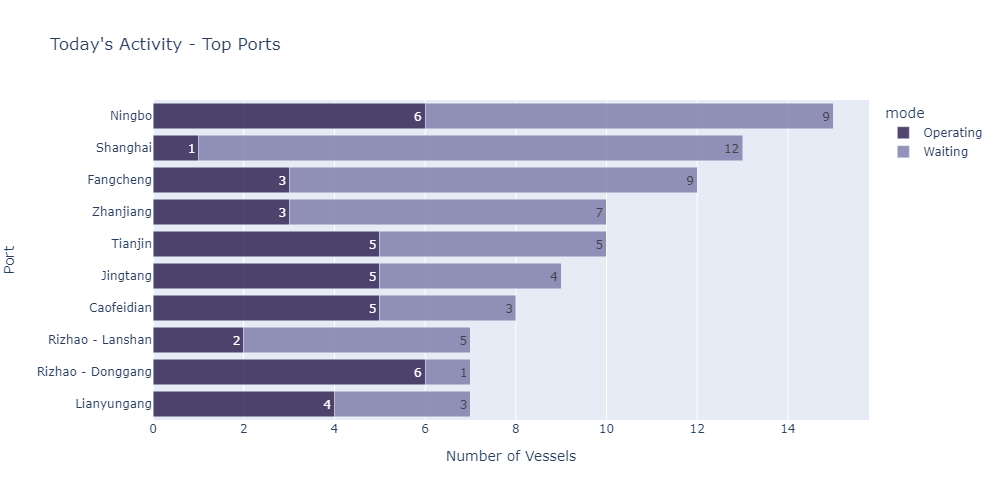

In [13]:
busiest_ports = calculate_busiest_ports(live_port_congestion)
plot_busiest_ports_barplot(busiest_ports)

- **Live Port Congestion Table** 

In [14]:
live_port_congestion

,imo,vessel_name,purpose,port_name_geos,country_geos,area_name_level0_geos,waiting_time_start,waiting_time_end,operating_time_start,operating_time_end,day_date,mode,geo_asset_name,latitude,longitude,arrival_date,days_at_port
0,9226633.0,Sunny Conakry,Discharge,Yantai,China,North China,2022-04-23 19:55:47,2022-04-24 23:59:00,2022-04-25 11:55:24,2022-04-26 10:58:32,2022-04-26,Operating,Yantai Bulk Terminal,37.7174,121.1133,2022-04-23 19:55:47,2.169595
1,9233923.0,Atlantis,Discharge,Jingtang,China,North China,2022-04-20 11:56:29,2022-04-21 23:59:00,2022-04-22 03:55:29,2022-04-26 07:55:32,2022-04-26,Operating,Jingtang Bulk Terminal,39.2424,119.0834,2022-04-20 11:56:29,5.502442
2,9252498.0,Lila Lisbon,Discharge,Lianyungang,China,North China,2022-04-20 23:56:52,2022-04-22 23:59:00,2022-04-23 03:54:16,2022-04-26 07:18:35,2022-04-26,Operating,Lianyungang Bulk Terminal,34.7487,119.4209,2022-04-20 23:56:52,5.002176
3,9271559.0,Cape Kori,Discharge,Zhanjiang,China,South China,2022-04-15 23:14:38,2022-04-23 23:59:00,2022-04-24 11:56:32,2022-04-26 08:43:34,2022-04-26,Operating,Zhanjiang Bulk Terminal,21.1643,110.4077,2022-04-15 23:14:38,10.031505
4,9300582.0,Cape Hawk,Discharge,Rizhao - Donggang,China,North China,2022-04-22 11:56:57,2022-04-23 23:59:00,2022-04-24 19:52:16,2022-04-26 03:52:20,2022-04-26,Operating,Rizhao - Donggang Bulk Terminal,35.3558,119.5454,2022-04-22 11:56:57,3.502118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,9889332.0,Hui Chang Hai,Discharge,Fangcheng,China,South China,2022-04-21 07:46:15,2022-05-01 17:00:39.085000+00:00,NaT,NaT,2022-04-26,Waiting,Fangcheng,21.6072,108.3267,2022-04-21 07:46:15,4.676215
138,9898761.0,Solar Quantum,Discharge,Bayuquan,China,North China,2022-04-20 03:59:51,2022-05-02 17:27:05.457000+00:00,NaT,NaT,2022-04-26,Waiting,Bayuquan Anchorage,40.1421,121.4840,2022-04-20 03:59:51,5.833438
139,9906013.0,Trust Qingdao,Discharge,Shanghai,China,Central China,2022-04-18 11:45:52,2022-05-02 05:47:22.647000+00:00,NaT,NaT,2022-04-26,Waiting,Shanghai Bulk Terminal,31.2032,122.7527,2022-04-18 11:45:52,7.509815
140,9920679.0,Ace Eternity,Discharge,Shanghai,China,Central China,2022-04-21 19:57:32,2022-05-03 12:15:36.796000+00:00,NaT,NaT,2022-04-26,Waiting,Shanghai Bulk Terminal,31.1356,122.6552,2022-04-21 19:57:32,4.168380
